In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/MyDrive/CS247/Models')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from util import *
from model import MLPEmbedding
from evaluate import *
import torch
import torch.nn as nn
from torch import optim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
train_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/train_data.pkl")
val_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/val_data.pkl")
test_data = pd.read_pickle("/content/drive/MyDrive/CS247/Data/test_data.pkl")[['review_profilename','beer_name','review_overall']]
test_data = merge_user_id(test_data, on='review_profilename').rename(columns={'id':'user_id'})
test_data = merge_beer_id(test_data, on='beer_name').rename(columns={'id':'beer_id'})[['user_id','beer_id','review_overall']]

In [ ]:
train_data.head()

user_id  beer_id  review_overall
383941      415      831             3.5
483700     2492     3491             4.0
375376     1233     1178             4.5
705138     1230      902             4.5
435972     2290     7497             3.5

In [ ]:
val_data.head()

user_id  beer_id  review_overall
1033343     1597     6355             5.0
1052177      106    10576             3.5
950364        54      484             3.5
1244606       35     5319             3.0
976342       429      486             4.5

In [ ]:
test_data.head()

user_id  beer_id  review_overall
0        0     5892             4.0
1        2     5892             4.0
2        9     5892             4.0
3       12     5892             4.0
4       17     5892             5.0

In [ ]:
print("Training data has length: ", len(train_data))
print("Validation data has length: ", len(val_data))
print("Test data has length: ", len(test_data))

Training data has length:  931875
Validation data has length:  316616
Test data has length:  300827


In [ ]:
# convert review score to boolean - if the item is relevant to the user (rating >= 3.5) then 1, else 0
threshold = 4.0
train_data['relevant'] = (train_data['review_overall'] >= threshold).astype(int)

In [ ]:
train_data.head()

user_id  beer_id  review_overall  relevant
383941      415      831             3.5         0
483700     2492     3491             4.0         1
375376     1233     1178             4.5         1
705138     1230      902             4.5         1
435972     2290     7497             3.5         0

In [ ]:
val_data.head()

user_id  beer_id  review_overall
1033343     1597     6355             5.0
1052177      106    10576             3.5
950364        54      484             3.5
1244606       35     5319             3.0
976342       429      486             4.5

In [ ]:
print("train data length: ", len(train_data))
print("val data length: ", len(val_data))
print("test data length:", len(test_data))


train data length:  931875
val data length:  316616
test data length: 300827


In [ ]:
### unique users & beers in train_data
n_users = len(train_data['user_id'].unique())
n_beers = len(train_data['beer_id'].unique())
print("unique users: ", n_users)
print("unique beers: ", n_beers)

unique users:  14811
unique beers:  52583


In [ ]:
import math

## device = gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## model params
n_hidden = 150
epochs = 40
batch_size = 500
lr = 0.0001
loss_fn = nn.BCELoss()
label_pred = 'pred_y'
k=5

mlp_embedding = MLPEmbedding(n_users=n_users, n_beers=n_beers, device=device, hidden_size=n_hidden).to(device)

optimizer = optim.Adam(mlp_embedding.parameters(), lr=lr, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

l = []
val_p = []
train_p = []
best_p = 0

for i in range(epochs):
    print("epoch: ",i)
    s = 0
    for bid in range(len(train_data) // batch_size):
        if (bid % 300 == 0):
          print("iteration: ",i, ", batch: ", bid)
        data = train_data[bid * batch_size : (bid + 1) * batch_size]
        optimizer.zero_grad()
        
        loss = mlp_embedding.loss(data, loss_fn)
        loss.backward()
        optimizer.step()
        s += loss
        
    # scheduler.step()
    l.append(s.item()/(len(data) // batch_size))  

    # evaluate precision at 10 of the model
  
    mlp_embedding.eval()
    with torch.no_grad():
      val = val_data.copy()
      val[label_pred] = (mlp_embedding.predict(val) > 0.5).astype(int)
      val_prec, _ = precision_recall_at_k(val, label_pred=label_pred, threshold=threshold, k=k)
      val_prec = sum(prec for prec in val_prec.values()) / len(val_prec)
      train = train_data.copy()
      train[label_pred] = (mlp_embedding.predict(train) > 0.5).astype(int)
      train_prec, _ = precision_recall_at_k(train, label_pred=label_pred, threshold=threshold, k=k)
      train_prec = sum(prec for prec in train_prec.values()) / len(train_prec)

      train_p.append(train_prec)
      val_p.append(val_prec)
    mlp_embedding.train()
    
    print("Train precision at 5: ", train_prec)
    print("Validation precision at 5: ", val_prec)
    print("Current best validation precision at 5: ", best_p)
    if val_prec > best_p:
      print("Test precision better than best current precision. Saving model...")
      torch.save({
           'model_state_dict': mlp_embedding.state_dict()
           }, "/content/drive/MyDrive/CS247/Models/checkpoints/mlp_embedding_best.pth")
      best_p = val_prec

      
    print("Average Loss for the current iteration: ", l[i])
    print("-----------------------------------")

epoch:  0
iteration:  0 , batch:  0
iteration:  0 , batch:  300
iteration:  0 , batch:  600
iteration:  0 , batch:  900
iteration:  0 , batch:  1200
iteration:  0 , batch:  1500
iteration:  0 , batch:  1800
Train precision at 5:  0.683439110570986
Validation precision at 5:  0.673301375104105
Current best validation precision at 5:  0
Test precision better than best current precision. Saving model...
Average Loss for the current iteration:  1213.1998291015625
-----------------------------------
epoch:  1
iteration:  1 , batch:  0
iteration:  1 , batch:  300
iteration:  1 , batch:  600
iteration:  1 , batch:  900
iteration:  1 , batch:  1200
iteration:  1 , batch:  1500
iteration:  1 , batch:  1800
Train precision at 5:  0.7020469020772989
Validation precision at 5:  0.6809938559179123
Current best validation precision at 5:  0.673301375104105
Test precision better than best current precision. Saving model...
Average Loss for the current iteration:  1147.2398681640625
------------------

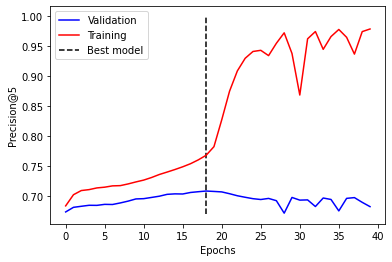

In [ ]:
# visualize average loss

import matplotlib.pyplot as plt

plt.plot(val_p, color='b', label='Validation')
plt.plot(train_p, color='r', label='Training')
plt.vlines(np.argmax(val_p),0.67,1.0, linestyles='dashed', label='Best model')
plt.ylabel('Precision@5')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
## n_users=14811
## n_beers=52583
## device:gpu
## hidden_size=100
best_model = MLPEmbedding(n_users=n_users, n_beers=n_beers, device=device, hidden_size=n_hidden)
best_model.load_state_dict(torch.load("/content/drive/MyDrive/CS247/Models/checkpoints/mlp_embedding_best.pth")['model_state_dict'])

<All keys matched successfully>

In [ ]:
#label_pred = 'pred_y'
best_model.to(device)
best_model.eval()
test_data[label_pred] = (best_model.predict(test_data)>0.5).cpu().detach().numpy().astype(int)
test_data

user_id  beer_id  review_overall  pred_y
0             0     5892             4.0       1
1             2     5892             4.0       1
2             9     5892             4.0       1
3            12     5892             4.0       1
4            17     5892             5.0       1
...         ...      ...             ...     ...
300822    14731    14334             2.5       0
300823    14776    42943             4.5       1
300824    14780    22042             4.5       1
300825    14785    36467             3.5       1
300826    14790    46338             2.0       0

[300827 rows x 4 columns]

In [ ]:
#threshold=4
#k=5
test_prec, test_recall = precision_recall_at_k(test_data, label_pred=label_pred, threshold=threshold, k=k)
# Precision and recall can then be averaged over all users
print("precision at 5 for test set: ", sum(prec for prec in test_prec.values()) / len(test_prec))
print("recall at 5 for test set:", sum(rec for rec in test_recall.values()) / len(test_prec))

precision at 5 for test set:  0.6797011866964071
recall at 5 for test set: 0.5438097404351361


In [ ]:
val_data[label_pred] = (best_model.predict(val_data)>0.5).cpu().detach().numpy().astype(int)
val_data
val_prec, val_recall = precision_recall_at_k(val_data, label_pred=label_pred, threshold=threshold, k=k)
# Precision and recall can then be averaged over all users
print("precision at 5 for validation set: ", sum(prec for prec in val_prec.values()) / len(val_prec))
print("recall at 5 for validation set:", sum(rec for rec in val_recall.values()) / len(val_prec))

precision at 5 for validation set:  0.7082033623658254
recall at 5 for validation set: 0.5758324402469728


In [ ]:
test_data[test_data['user_id']==0]

user_id  beer_id  review_overall  pred_y
0            0     5892             4.0       1
96           0     9202             4.0       0
156          0    18492             3.5       0
161          0     5624             3.5       1
220          0     4872             4.5       1
...        ...      ...             ...     ...
44485        0    18487             4.0       1
44487        0    18466             3.5       0
44490        0     5748             4.5       1
44543        0    12886             3.5       0
44544        0     7941             4.0       1

[1096 rows x 4 columns]

In [ ]:
precisions, recalls = precision_recall_at_k(test_data[test_data['user_id']==0], label_pred=label_pred, threshold=threshold, k=k)
print("precision at 5 for user 0: ", sum(prec for prec in precisions.values()) / len(precisions))
print("recall at 5 for user 0:", sum(rec for rec in recalls.values()) / len(recalls))

precision at 5 for user 0:  0.6
recall at 5 for user 0: 0.005190311418685121
